# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
2. Scroll down to API and click Create New API Token.
3. Open up `kaggle.json` and use the username and key.

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached pip-22.3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
  Using cached setuptools-65.6.3-py3-none-any.whl (1.2 MB)
  Using cached wheel-0.38.4-py3-none-any.whl (36 kB)
  Attempting uninstall: wheel
    Found existing installation: wheel 0.34.2
    Uninstalling wheel-0.34.2:
      Successfully uninstalled wheel-0.34.2
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.3.0
    Uninstalling setuptools-59.3.0:
      Successfully uninstalled setuptools-59.3.0
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.2
    Uninstalling bokeh-2.4.2:
      Successfully uninstalled bokeh-2.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.7/289.7 kB 181.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

### Setup Kaggle API Key

In [3]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!pip install -U kaggle
!ln -s /root/.local/bin/kaggle /usr/bin/kaggle

  Using cached kaggle-1.5.12-py3-none-any.whl
  Using cached python_slugify-7.0.0-py2.py3-none-any.whl (9.4 kB)


In [5]:
!pip install python-dotenv

  Using cached python_dotenv-0.21.0-py3-none-any.whl (18 kB)


In [6]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
from dotenv import dotenv_values

CONFIG = dotenv_values('.env')
kaggle_username = CONFIG['KAGGLE_USERNAME']
kaggle_key = CONFIG['KAGGLE_KEY']

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

### Go to the bike sharing demand competition and agree to the terms

In [7]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [8]:
import pandas as pd
from autogluon.tabular import TabularPredictor

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv", parse_dates=["datetime"])
#train["datetime"]=pd.to_datetime(train["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [10]:
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [11]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [12]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv", parse_dates=["datetime"])
#test["datetime"]=pd.to_datetime(test["datetime"]
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [13]:
test.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
dtype: object

In [14]:
# Same thing as train and test dataset
submission = pd.read_csv("submission.csv", parse_dates=["datetime"])
#submission["datetime"]=pd.to_datetime(submission["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,23.067333
1,2011-01-20 01:00:00,39.728054
2,2011-01-20 02:00:00,44.768307
3,2011-01-20 03:00:00,48.401352
4,2011-01-20 04:00:00,51.908775


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [15]:
train.loc[:, ~train.columns.isin(["casual","registered"])]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,129


In [16]:
predictor = TabularPredictor(label="count", eval_metric="root_mean_squared_error").fit(
    train_data=train.loc[:,~train.columns.isin(["casual","registered"])],
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230110_032606/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230110_032606/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fea

### Review AutoGluon's training run with ranking of models that did the best.

In [17]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.845193      11.795183  433.789987                0.000848           0.339937            3       True         16
1   RandomForestMSE_BAG_L2  -53.305711      10.941317  403.020502                0.624003          25.608316            2       True         12
2     ExtraTreesMSE_BAG_L2  -54.044861      10.949608  385.579941                0.632293           8.167755            2       True         14
3          LightGBM_BAG_L2  -55.185654      10.538040  399.673979                0.220726          22.261793            2       True         11
4          CatBoost_BAG_L2  -55.801889      10.369169  440.752473                0.051854          63.340287            2       True         13
5        LightGBMXT_BAG_L2  -60.536179      13.749781  427.346090         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602

### Create predictions from test dataset

In [18]:
predictions = predictor.predict(test)
predictions.head()

0    21.968969
1    41.089344
2    45.081524
3    49.228630
4    52.367203
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [19]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.609985
std        90.121147
min         2.945020
25%        20.638458
50%        63.068729
75%       168.771606
max       362.625671
Name: count, dtype: float64

In [20]:
# How many negative values do we have?
(predictions<0).sum().sum()

0

In [21]:
# Set them to zero
predictions.iloc[predictions<0] = 0
predictions.lt(0).value_counts()

False    6493
Name: count, dtype: int64

### Set predictions to submission dataframe, save, and submit

In [22]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [23]:
submission

,datetime,count
0,2011-01-20 00:00:00,21.968969
1,2011-01-20 01:00:00,41.089344
2,2011-01-20 02:00:00,45.081524
3,2011-01-20 03:00:00,49.228630
4,2011-01-20 04:00:00,52.367203
...,...,...
6488,2012-12-31 19:00:00,159.467545
6489,2012-12-31 20:00:00,159.489914
6490,2012-12-31 21:00:00,153.066742
6491,2012-12-31 22:00:00,149.910873


In [24]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 340kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [25]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission.csv               2023-01-10 03:38:40  first raw submission                 complete  1.80562      1.80562       
submission_new_features.csv  2023-01-09 17:16:07  new features                         complete  1.76199      1.76199       
submission.csv               2023-01-09 16:15:34  first raw submission                 complete  1.81103      1.81103       
submission.csv               2023-01-09 04:52:16  first raw submission                 complete  1.79810      1.79810       
tail: write error: Broken pipe


#### Initial score of `?`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

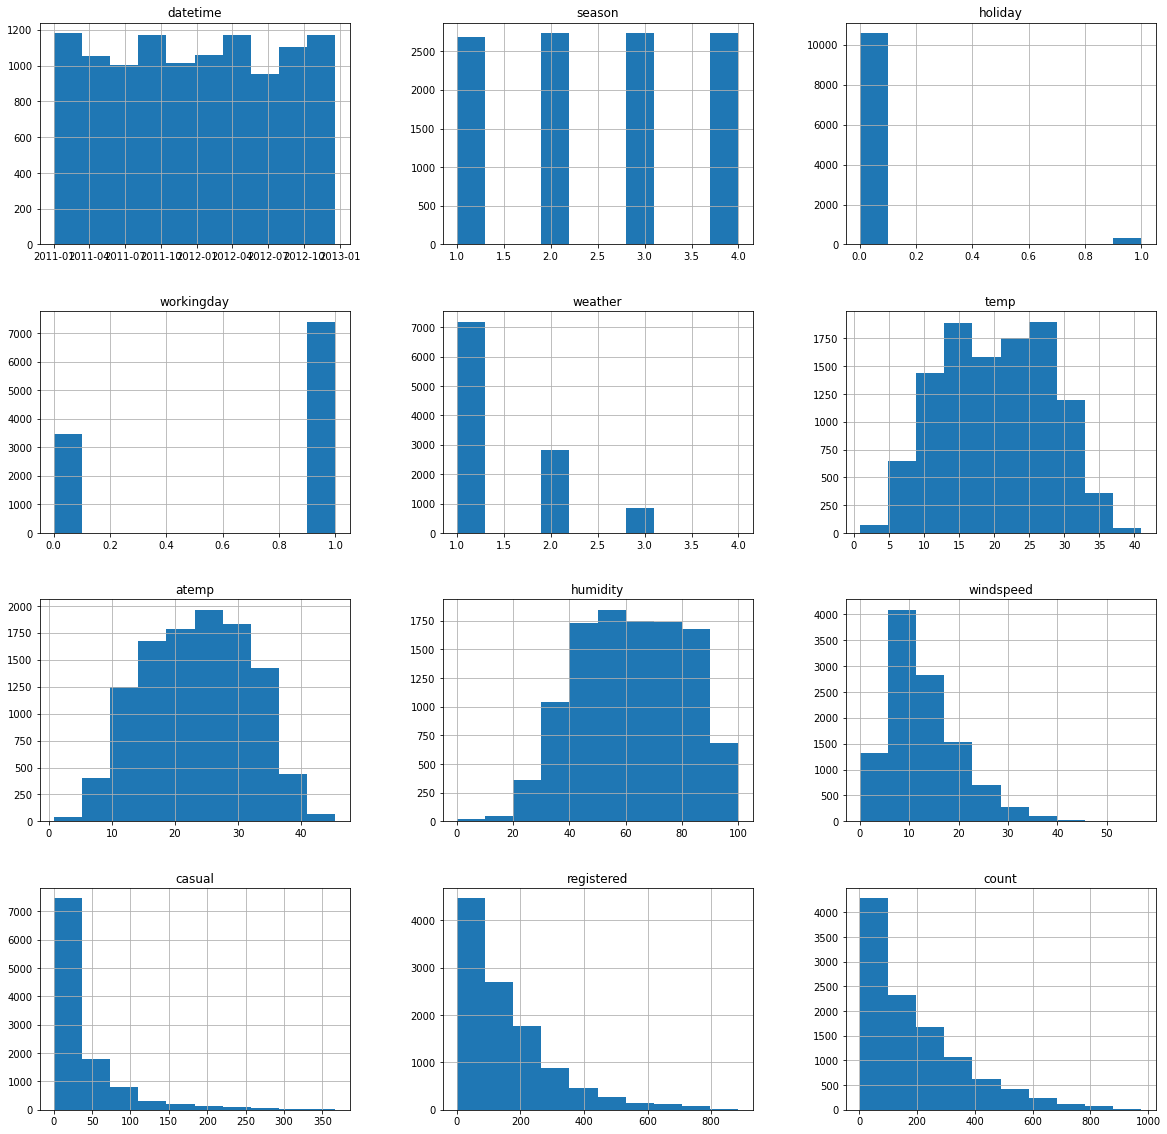

In [26]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(20,20));

In [27]:
!pip install -U tsfresh

  Using cached tsfresh-0.20.0-py2.py3-none-any.whl (98 kB)
  Using cached stumpy-1.11.1-py3-none-any.whl (136 kB)


In [28]:
from tsfresh import extract_features
extracted_features_train = extract_features(train, column_id="datetime", column_value="temp")

Feature Extraction: 100%|██████████| 10886/10886 [04:20<00:00, 41.75it/s]


In [29]:
extracted_features_train

,temp__variance_larger_than_standard_deviation,temp__has_duplicate_max,temp__has_duplicate_min,temp__has_duplicate,temp__sum_values,temp__abs_energy,temp__mean_abs_change,temp__mean_change,temp__mean_second_derivative_central,temp__median,...,temp__fourier_entropy__bins_5,temp__fourier_entropy__bins_10,temp__fourier_entropy__bins_100,temp__permutation_entropy__dimension_3__tau_1,temp__permutation_entropy__dimension_4__tau_1,temp__permutation_entropy__dimension_5__tau_1,temp__permutation_entropy__dimension_6__tau_1,temp__permutation_entropy__dimension_7__tau_1,temp__query_similarity_count__query_None__threshold_0.0,temp__mean_n_absolute_max__number_of_maxima_7
2011-01-01 00:00:00,0.0,0.0,0.0,0.0,9.84,96.8256,NaN,NaN,NaN,9.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,9.02,81.3604,NaN,NaN,NaN,9.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 02:00:00,0.0,0.0,0.0,0.0,9.02,81.3604,NaN,NaN,NaN,9.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 03:00:00,0.0,0.0,0.0,0.0,9.84,96.8256,NaN,NaN,NaN,9.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 04:00:00,0.0,0.0,0.0,0.0,9.84,96.8256,NaN,NaN,NaN,9.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,0.0,0.0,0.0,0.0,15.58,242.7364,NaN,NaN,NaN,15.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-19 20:00:00,0.0,0.0,0.0,0.0,14.76,217.8576,NaN,NaN,NaN,14.76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-19 21:00:00,0.0,0.0,0.0,0.0,13.94,194.3236,NaN,NaN,NaN,13.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-19 22:00:00,0.0,0.0,0.0,0.0,13.94,194.3236,NaN,NaN,NaN,13.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
temp_sum_values_train=extracted_features_train.temp__sum_values
temp_sum_values_train=temp_sum_values_train.to_frame()
temp_sum_values_train =temp_sum_values_train.reset_index(drop=True)

In [33]:
temp_sum_values_train["temp__sum_values"]

0         9.84
1         9.02
2         9.02
3         9.84
4         9.84
         ...  
10881    15.58
10882    14.76
10883    13.94
10884    13.94
10885    13.12
Name: temp__sum_values, Length: 10886, dtype: float64

In [34]:
extracted_features_test = extract_features(test, column_id="datetime", column_value="temp")

Feature Extraction: 100%|██████████| 6493/6493 [02:35<00:00, 41.66it/s]


In [35]:
extracted_features_test

,temp__variance_larger_than_standard_deviation,temp__has_duplicate_max,temp__has_duplicate_min,temp__has_duplicate,temp__sum_values,temp__abs_energy,temp__mean_abs_change,temp__mean_change,temp__mean_second_derivative_central,temp__median,...,temp__fourier_entropy__bins_5,temp__fourier_entropy__bins_10,temp__fourier_entropy__bins_100,temp__permutation_entropy__dimension_3__tau_1,temp__permutation_entropy__dimension_4__tau_1,temp__permutation_entropy__dimension_5__tau_1,temp__permutation_entropy__dimension_6__tau_1,temp__permutation_entropy__dimension_7__tau_1,temp__query_similarity_count__query_None__threshold_0.0,temp__mean_n_absolute_max__number_of_maxima_7
2011-01-20 00:00:00,0.0,0.0,0.0,0.0,10.66,113.6356,NaN,NaN,NaN,10.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-20 01:00:00,0.0,0.0,0.0,0.0,10.66,113.6356,NaN,NaN,NaN,10.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-20 02:00:00,0.0,0.0,0.0,0.0,10.66,113.6356,NaN,NaN,NaN,10.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-20 03:00:00,0.0,0.0,0.0,0.0,10.66,113.6356,NaN,NaN,NaN,10.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-20 04:00:00,0.0,0.0,0.0,0.0,10.66,113.6356,NaN,NaN,NaN,10.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,0.0,0.0,0.0,0.0,10.66,113.6356,NaN,NaN,NaN,10.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-31 20:00:00,0.0,0.0,0.0,0.0,10.66,113.6356,NaN,NaN,NaN,10.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-31 21:00:00,0.0,0.0,0.0,0.0,10.66,113.6356,NaN,NaN,NaN,10.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-12-31 22:00:00,0.0,0.0,0.0,0.0,10.66,113.6356,NaN,NaN,NaN,10.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
temp_sum_values_test=extracted_features_test.temp__sum_values
temp_sum_values_test=temp_sum_values_test.to_frame()
temp_sum_values_test =temp_sum_values_test.reset_index(drop=True)

In [37]:
temp_sum_values_test["temp__sum_values"]

0       10.66
1       10.66
2       10.66
3       10.66
4       10.66
        ...  
6488    10.66
6489    10.66
6490    10.66
6491    10.66
6492    10.66
Name: temp__sum_values, Length: 6493, dtype: float64

In [38]:
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [39]:
# create a new feature
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["dayofweek"] = train["datetime"].dt.dayofweek
train["temp__sum_values"] = temp_sum_values_train["temp__sum_values"]
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["dayofweek"] = test["datetime"].dt.dayofweek
test["temp__sum_values"] = temp_sum_values_test["temp__sum_values"]

In [40]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,temp__sum_values
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,9.84
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,9.02
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,9.02
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,9.84
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,9.84


In [41]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,dayofweek,temp__sum_values
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,3,10.66
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,10.66
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,10.66
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,10.66
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,10.66


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [42]:
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
train["day"] = train["day"].astype("category")
train["month"] = train["month"].astype("category")
train["year"] = train["year"].astype("category")
train["dayofweek"] = train["dayofweek"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")
test["day"] = test["day"].astype("category")
test["month"] = test["month"].astype("category")
test["year"] = test["year"].astype("category")
test["dayofweek"] = test["dayofweek"].astype("category")

In [43]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,dayofweek,temp__sum_values
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,9.84
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,9.02
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,9.02
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,9.84
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,9.84


In [44]:
train.dtypes

datetime            datetime64[ns]
season                    category
holiday                      int64
workingday                   int64
weather                   category
temp                       float64
atemp                      float64
humidity                     int64
windspeed                  float64
casual                       int64
registered                   int64
count                        int64
year                      category
month                     category
day                       category
dayofweek                 category
temp__sum_values           float64
dtype: object

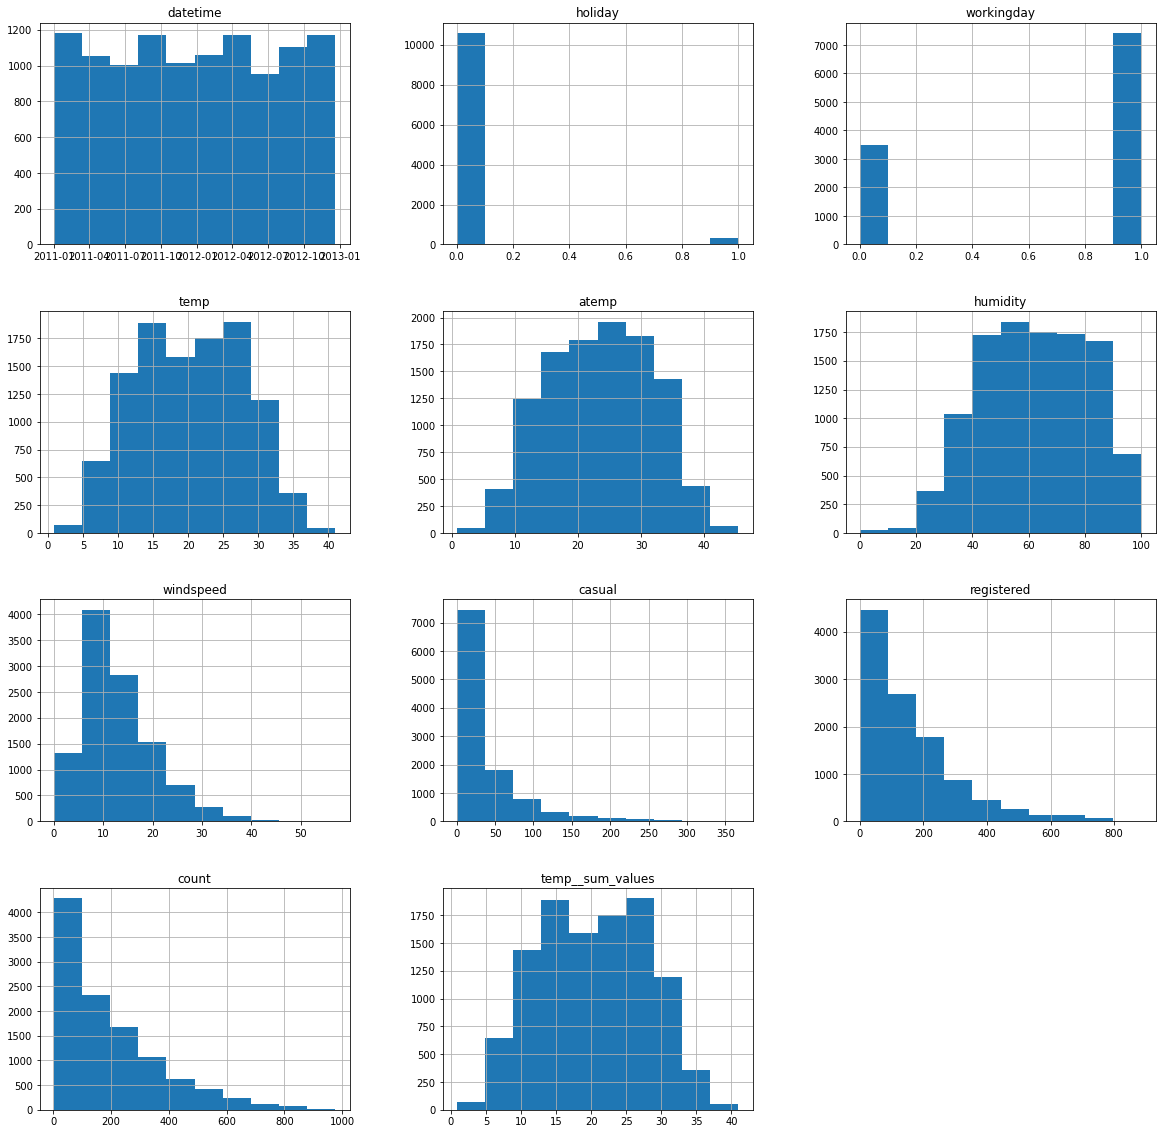

In [45]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(20,20));

## Step 5: Rerun the model with the same settings as before, just with more features

In [46]:
predictor_new_features = TabularPredictor(label="count", eval_metric="root_mean_squared_error").fit(
    train_data=train.loc[:,~train.columns.isin(["casual","registered"])],
    time_limit=600,
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230110_034956/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230110_034956/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 14
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fe

In [47]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.907886      11.270663  447.771362                0.001011           0.317856            3       True         14
1   RandomForestMSE_BAG_L2  -53.142450      10.973328  423.563932                0.652528          29.105148            2       True         12
2          LightGBM_BAG_L2  -55.117661      10.617125  418.348358                0.296325          23.889573            2       True         11
3          CatBoost_BAG_L2  -57.364045      10.461172  452.388560                0.140372          57.929776            2       True         13
4        LightGBMXT_BAG_L2  -63.338282      14.640675  452.721812                4.319875          58.263027            2       True         10
5    KNeighborsDist_BAG_L1  -84.125061       0.071695    0.054585         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -130.6566502834966,
  'LightGBM_BAG_L1': -130.5004807127159,
  'RandomForestMSE_BAG_L1': -116.73

In [48]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    23.306042
1    42.258221
2    46.107113
3    49.283066
4    51.383648
Name: count, dtype: float32

In [53]:
predictions_new_features.describe()

count    6493.000000
mean      101.446732
std        89.460556
min         3.254764
25%        23.253716
50%        63.402252
75%       166.449402
max       362.405151
Name: count, dtype: float64

In [54]:
predictions_new_features.iloc[predictions_new_features<0] = 0
predictions_new_features.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [55]:
# Same submitting predictions
submission_new_features=pd.read_csv("submission_new_features.csv")
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [56]:
submission_new_features=pd.read_csv("submission_new_features.csv")
submission_new_features.head()

,datetime,count
0,2011-01-20 00:00:00,23.306042
1,2011-01-20 01:00:00,42.258220
2,2011-01-20 02:00:00,46.107113
3,2011-01-20 03:00:00,49.283066
4,2011-01-20 04:00:00,51.383648


In [57]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 385kB/s]
Successfully submitted to Bike Sharing Demand

In [58]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_features.csv  2023-01-10 04:02:45  new features                         complete  1.75632      1.75632       
submission.csv               2023-01-10 03:38:40  first raw submission                 complete  1.80562      1.80562       
submission_new_features.csv  2023-01-09 17:16:07  new features                         complete  1.76199      1.76199       
submission.csv               2023-01-09 16:15:34  first raw submission                 complete  1.81103      1.81103       
tail: write error: Broken pipe


#### New Score of `?`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [111]:
predictor_new_hpo = TabularPredictor(label="count", eval_metric="root_mean_squared_error").fit(
    train_data=train.loc[:,~train.columns.isin(["casual","registered"])],
    time_limit=600,
    num_bag_folds=5,
    num_bag_sets=1,
    num_stack_levels=1,
    hyperparameters = {
        'GBM': [
            {
                'extra_trees': True, 
                'ag_args': {
                    'name_suffix': 'XT'
                }
            }, {}, 'GBMLarge',],
        'RF': [
            {
                'criterion': 'gini', 
                'ag_args': {
                    'name_suffix': 'Gini', 
                    'problem_types': ['binary', 'multiclass']
                }
            }, 
            {
                'criterion': 'entropy', 
                'ag_args': {
                    'name_suffix': 'Entr', 
                    'problem_types': ['binary', 'multiclass']
                }
            }, 
            {
                'criterion': 'squared_error', 
                'ag_args': {
                    'name_suffix': 'MSE', 'problem_types': ['regression']
                }
            }
        ],
        'XT': [
            {
                'criterion': 'gini', 
                'ag_args': {
                    'name_suffix': 'Gini', 
                    'problem_types': ['binary', 'multiclass']
                }
            }, 
            {
                'criterion': 'entropy', 
                'ag_args': {
                    'name_suffix': 'Entr', 
                    'problem_types': ['binary', 'multiclass']
                }
            }, 
            {
                'criterion': 'squared_error', 
                'ag_args': {
                    'name_suffix': 'MSE', 'problem_types': ['regression']
                }
            },
        ],
        'KNN': [

            {
                'weights': 'uniform', 
                'ag_args': {
                    'name_suffix': 'Unif'
                }
            }, 
            {
                'weights': 'distance', 
                'ag_args': {
                    'name_suffix': 'Dist'
                }
            },

        ],
    },
    hyperparameter_tune_kwargs = 'auto',
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230110_173342/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230110_173342/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 14
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fea

In [112]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.816167       0.700257  202.222389                0.000818           0.380783            3       True         19
1   RandomForestMSE_BAG_L2  -53.282864       0.699004  152.510306                0.000251          32.907052            2       True         16
2     ExtraTreesMSE_BAG_L2  -54.162182       0.698980  132.433230                0.000227          12.829976            2       True         17
3       LightGBM_BAG_L2/T1  -55.596705       0.698868  136.855442                0.000115          17.252187            2       True         12
4       LightGBM_BAG_L2/T2  -55.615175       0.698838  138.692040                0.000086          19.088786            2       True         13
5     LightGBMLarge_BAG_L2  -55.758014       1.027843  143.832775         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBMXT_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T4': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'LightGBMLarge_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'W

In [113]:
test.dtypes

datetime            datetime64[ns]
season                    category
holiday                      int64
workingday                   int64
weather                   category
temp                       float64
atemp                      float64
humidity                     int64
windspeed                  float64
year                      category
month                     category
day                       category
dayofweek                 category
temp__sum_values           float64
dtype: object

In [114]:
predictions_new_hpo_1 = predictor_new_hpo.predict(test)
predictions_new_hpo_1.head()

0    22.466658
1    40.896370
2    44.372551
3    49.112778
4    51.930977
Name: count, dtype: float32

In [115]:
# Remember to set all negative values to zero
predictions_new_hpo_1.iloc[predictions_new_hpo_1<0] = 0
predictions_new_hpo_1.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [116]:
# Same submitting predictions
submission_new_hpo=pd.read_csv("submission_new_hpo.csv")
submission_new_hpo["count"] = predictions_new_hpo_1
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [117]:
submission_new_hpo = pd.read_csv("submission_new_hpo.csv")
submission_new_hpo.head()

,datetime,count
0,2011-01-20 00:00:00,22.466658
1,2011-01-20 01:00:00,40.896370
2,2011-01-20 02:00:00,44.372550
3,2011-01-20 03:00:00,49.112778
4,2011-01-20 04:00:00,51.930977


In [118]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 369kB/s]
Successfully submitted to Bike Sharing Demand

In [119]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-01-10 21:28:41  new features with hyperparameters    complete  1.77921      1.77921       
submission_new_hpo.csv       2023-01-10 06:25:55  new features with hyperparameters    complete  1.31474      1.31474       
submission_new_hpo.csv       2023-01-10 05:57:18  new features with hyperparameters    complete  1.31474      1.31474       
submission_new_features.csv  2023-01-10 04:02:45  new features                         complete  1.75632      1.75632       
tail: write error: Broken pipe


In [122]:
predictor_new_hpo = TabularPredictor(label="count", eval_metric="root_mean_squared_error").fit(
    train_data=train.loc[:,~train.columns.isin(["casual","registered"])],
    time_limit=600,
    num_bag_folds=0,
    num_bag_sets=20,
    num_stack_levels=0,
    hyperparameters = {
        'GBM': [
            {
                'extra_trees': True, 
                'ag_args': {
                    'name_suffix': 'XT'
                }
            }, {}, 'GBMLarge',],
        'RF': [
            {
                'criterion': 'gini', 
                'ag_args': {
                    'name_suffix': 'Gini', 
                    'problem_types': ['binary', 'multiclass']
                }
            }, 
            {
                'criterion': 'entropy', 
                'ag_args': {
                    'name_suffix': 'Entr', 
                    'problem_types': ['binary', 'multiclass']
                }
            }, 
            {
                'criterion': 'squared_error', 
                'ag_args': {
                    'name_suffix': 'MSE', 'problem_types': ['regression']
                }
            }
        ],
        'XT': [
            {
                'criterion': 'gini', 
                'ag_args': {
                    'name_suffix': 'Gini', 
                    'problem_types': ['binary', 'multiclass']
                }
            }, 
            {
                'criterion': 'entropy', 
                'ag_args': {
                    'name_suffix': 'Entr', 
                    'problem_types': ['binary', 'multiclass']
                }
            }, 
            {
                'criterion': 'squared_error', 
                'ag_args': {
                    'name_suffix': 'MSE', 'problem_types': ['regression']
                }
            },
        ],
        'KNN': [

            {
                'weights': 'uniform', 
                'ag_args': {
                    'name_suffix': 'Unif'
                }
            }, 
            {
                'weights': 'distance', 
                'ag_args': {
                    'name_suffix': 'Dist'
                }
            },

        ],
    },
    hyperparameter_tune_kwargs = 'auto',
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230110_213420/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=0, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230110_213420/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 14
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Fe

[1000]	valid_set's rmse: 133.778
[2000]	valid_set's rmse: 133.431
[1000]	valid_set's rmse: 133.381
[1000]	valid_set's rmse: 135.14
[2000]	valid_set's rmse: 133.797
[3000]	valid_set's rmse: 133.212
[4000]	valid_set's rmse: 132.699
[5000]	valid_set's rmse: 132.412
[6000]	valid_set's rmse: 132.278
[7000]	valid_set's rmse: 132.208
[8000]	valid_set's rmse: 132.129
[9000]	valid_set's rmse: 132.142
[10000]	valid_set's rmse: 132.23
[1000]	valid_set's rmse: 133.428
[2000]	valid_set's rmse: 132.431
[3000]	valid_set's rmse: 132.384
[1000]	valid_set's rmse: 134.07
[1000]	valid_set's rmse: 133.357


	Stopping HPO to satisfy time limit...
Fitted model: LightGBMXT/T1 ...
	-133.2099	 = Validation score   (-root_mean_squared_error)
	3.5s	 = Training   runtime
	0.34s	 = Validation runtime
Fitted model: LightGBMXT/T2 ...
	-132.4597	 = Validation score   (-root_mean_squared_error)
	2.54s	 = Training   runtime
	0.18s	 = Validation runtime
Fitted model: LightGBMXT/T3 ...
	-133.1688	 = Validation score   (-root_mean_squared_error)
	4.58s	 = Training   runtime
	0.37s	 = Validation runtime
Fitted model: LightGBMXT/T4 ...
	-132.124	 = Validation score   (-root_mean_squared_error)
	25.85s	 = Training   runtime
	5.82s	 = Validation runtime
Fitted model: LightGBMXT/T5 ...
	-133.9775	 = Validation score   (-root_mean_squared_error)
	2.18s	 = Training   runtime
	0.14s	 = Validation runtime
Fitted model: LightGBMXT/T6 ...
	-132.3127	 = Validation score   (-root_mean_squared_error)
	10.11s	 = Training   runtime
	0.82s	 = Validation runtime
Fitted model: LightGBMXT/T7 ...
	-133.7736	 = Validation scor

[1000]	valid_set's rmse: 133.276
[2000]	valid_set's rmse: 132.279
[1000]	valid_set's rmse: 132.293
[1000]	valid_set's rmse: 133.139
[2000]	valid_set's rmse: 132.594
[3000]	valid_set's rmse: 132.756
[1000]	valid_set's rmse: 132.442
[1000]	valid_set's rmse: 133.519
[2000]	valid_set's rmse: 133.016
[3000]	valid_set's rmse: 133.133
[1000]	valid_set's rmse: 132.705
[1000]	valid_set's rmse: 134.254
[2000]	valid_set's rmse: 133.693
[3000]	valid_set's rmse: 133.817
[1000]	valid_set's rmse: 136.198
[2000]	valid_set's rmse: 134.89
[3000]	valid_set's rmse: 133.867
[4000]	valid_set's rmse: 133.602
[5000]	valid_set's rmse: 133.363
[6000]	valid_set's rmse: 133.285
[7000]	valid_set's rmse: 133.223
[8000]	valid_set's rmse: 133.172
[9000]	valid_set's rmse: 133.191


	Stopping HPO to satisfy time limit...
Fitted model: LightGBM/T1 ...
	-132.4749	 = Validation score   (-root_mean_squared_error)
	1.49s	 = Training   runtime
	0.09s	 = Validation runtime
Fitted model: LightGBM/T2 ...
	-131.6196	 = Validation score   (-root_mean_squared_error)
	1.36s	 = Training   runtime
	0.04s	 = Validation runtime
Fitted model: LightGBM/T3 ...
	-133.192	 = Validation score   (-root_mean_squared_error)
	2.29s	 = Training   runtime
	0.17s	 = Validation runtime
Fitted model: LightGBM/T4 ...
	-132.119	 = Validation score   (-root_mean_squared_error)
	7.01s	 = Training   runtime
	0.53s	 = Validation runtime
Fitted model: LightGBM/T5 ...
	-133.0747	 = Validation score   (-root_mean_squared_error)
	1.27s	 = Training   runtime
	0.05s	 = Validation runtime
Fitted model: LightGBM/T6 ...
	-132.2833	 = Validation score   (-root_mean_squared_error)
	3.69s	 = Training   runtime
	0.26s	 = Validation runtime
Fitted model: LightGBM/T7 ...
	-133.6469	 = Validation score   (-root_mean_

In [123]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        KNeighborsDist  -94.488129       0.035333   0.012527                0.035333           0.012527            1       True          2
1   WeightedEnsemble_L2  -97.583924       0.035846   0.360365                0.000513           0.347838            2       True         29
2        KNeighborsUnif -112.769894       0.045850   0.046662                0.045850           0.046662            1       True          1
3       RandomForestMSE -120.851959       0.547585  10.011806                0.547585          10.011806            1       True         26
4         ExtraTreesMSE -127.321630       0.527177   5.058264                0.527177           5.058264            1       True         27
5           LightGBM/T2 -131.619623       0.035794   1.362758                0.035794           1.

{'model_types': {'KNeighborsUnif': 'KNNModel',
  'KNeighborsDist': 'KNNModel',
  'LightGBMXT/T1': 'LGBModel',
  'LightGBMXT/T2': 'LGBModel',
  'LightGBMXT/T3': 'LGBModel',
  'LightGBMXT/T4': 'LGBModel',
  'LightGBMXT/T5': 'LGBModel',
  'LightGBMXT/T6': 'LGBModel',
  'LightGBMXT/T7': 'LGBModel',
  'LightGBMXT/T8': 'LGBModel',
  'LightGBM/T1': 'LGBModel',
  'LightGBM/T2': 'LGBModel',
  'LightGBM/T3': 'LGBModel',
  'LightGBM/T4': 'LGBModel',
  'LightGBM/T5': 'LGBModel',
  'LightGBM/T6': 'LGBModel',
  'LightGBM/T7': 'LGBModel',
  'LightGBM/T8': 'LGBModel',
  'LightGBM/T9': 'LGBModel',
  'LightGBM/T10': 'LGBModel',
  'LightGBM/T11': 'LGBModel',
  'LightGBM/T12': 'LGBModel',
  'LightGBM/T13': 'LGBModel',
  'LightGBM/T14': 'LGBModel',
  'LightGBM/T15': 'LGBModel',
  'RandomForestMSE': 'RFModel',
  'ExtraTreesMSE': 'XTModel',
  'LightGBMLarge': 'LGBModel',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif': -112.76989371124893,
  'KNeighborsDist': -94.48

In [125]:
predictor_new_hpo.leaderboard();

                  model   score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        KNeighborsDist  -94.488129       0.035333   0.012527                0.035333           0.012527            1       True          2
1   WeightedEnsemble_L2  -97.583924       0.035846   0.360365                0.000513           0.347838            2       True         29
2        KNeighborsUnif -112.769894       0.045850   0.046662                0.045850           0.046662            1       True          1
3       RandomForestMSE -120.851959       0.547585  10.011806                0.547585          10.011806            1       True         26
4         ExtraTreesMSE -127.321630       0.527177   5.058264                0.527177           5.058264            1       True         27
5           LightGBM/T2 -131.619623       0.035794   1.362758                0.035794           1.362758            1       True         12
6         LightGBMLa

In [126]:
predictions_new_hpo2 = predictor_new_hpo.predict(test)
predictions_new_hpo2.head()

0    51.861626
1    56.686295
2    59.077763
3    60.468830
4    61.419930
Name: count, dtype: float32

In [127]:
# Remember to set all negative values to zero
predictions_new_hpo2.iloc[predictions_new_hpo2<0] = 0
predictions_new_hpo2.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [128]:
# Same submitting predictions
submission_new_hpo_2=pd.read_csv("submission_new_hpo_2.csv")
submission_new_hpo_2["count"] = predictions_new_hpo2
submission_new_hpo_2.to_csv("submission_new_hpo_2.csv", index=False)

In [129]:
submission_new_hpo_2 = pd.read_csv("submission_new_hpo_2.csv")
submission_new_hpo_2.head()

,datetime,count
0,2011-01-20 00:00:00,51.861626
1,2011-01-20 01:00:00,56.686295
2,2011-01-20 02:00:00,59.077763
3,2011-01-20 03:00:00,60.468830
4,2011-01-20 04:00:00,61.419930


In [130]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo_2.csv -m "new features with hyperparameters-2"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 445kB/s]
Successfully submitted to Bike Sharing Demand

In [131]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_hpo_2.csv     2023-01-10 21:38:47  new features with hyperparameters-2  complete  1.83641      1.83641       
submission_new_hpo.csv       2023-01-10 21:28:41  new features with hyperparameters    complete  1.77921      1.77921       
submission_new_hpo.csv       2023-01-10 06:25:55  new features with hyperparameters    complete  1.31474      1.31474       
submission_new_hpo.csv       2023-01-10 05:57:18  new features with hyperparameters    complete  1.31474      1.31474       
tail: write error: Broken pipe


In [133]:
predictor_new_hpo = TabularPredictor(label="count", eval_metric="root_mean_squared_error").fit(
    train_data=train.loc[:,~train.columns.isin(["casual","registered"])],
    time_limit=600,
    num_bag_folds=10,
    num_bag_sets=20,
    num_stack_levels=3,
    hyperparameters = {
        'GBM': [
            {
                'extra_trees': True, 
                'ag_args': {
                    'name_suffix': 'XT'
                }
            }, {}, 'GBMLarge',],
        'RF': [
            {
                'criterion': 'gini', 
                'ag_args': {
                    'name_suffix': 'Gini', 
                    'problem_types': ['binary', 'multiclass']
                }
            }, 
            {
                'criterion': 'entropy', 
                'ag_args': {
                    'name_suffix': 'Entr', 
                    'problem_types': ['binary', 'multiclass']
                }
            }, 
            {
                'criterion': 'squared_error', 
                'ag_args': {
                    'name_suffix': 'MSE', 'problem_types': ['regression']
                }
            }
        ],
        'XT': [
            {
                'criterion': 'gini', 
                'ag_args': {
                    'name_suffix': 'Gini', 
                    'problem_types': ['binary', 'multiclass']
                }
            }, 
            {
                'criterion': 'entropy', 
                'ag_args': {
                    'name_suffix': 'Entr', 
                    'problem_types': ['binary', 'multiclass']
                }
            }, 
            {
                'criterion': 'squared_error', 
                'ag_args': {
                    'name_suffix': 'MSE', 'problem_types': ['regression']
                }
            },
        ],
        'KNN': [

            {
                'weights': 'uniform', 
                'ag_args': {
                    'name_suffix': 'Unif'
                }
            }, 
            {
                'weights': 'distance', 
                'ag_args': {
                    'name_suffix': 'Dist'
                }
            },

        ],
    },
    hyperparameter_tune_kwargs = 'auto',
    presets="best_quality"
)

No path specified. Models will be saved in: "AutogluonModels/ag-20230110_214915/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=10, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230110_214915/"
AutoGluon Version:  0.6.1
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    10886
Train Data Columns: 14
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using F

In [134]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.588371       2.085567  284.563781                0.001044           0.385196            3       True         14
1      WeightedEnsemble_L4  -53.163039       2.086634  442.332659                0.000856           0.294894            4       True         20
2   RandomForestMSE_BAG_L2  -53.203529       1.547582  189.578948                0.000264          31.295402            2       True         11
3     ExtraTreesMSE_BAG_L3  -53.447232       2.084870  351.080944                0.000263          12.185489            3       True         18
4       LightGBM_BAG_L3/T1  -53.792176       2.084728  369.702935                0.000122          30.807480            3       True         16
5   RandomForestMSE_BAG_L3  -53.806669       2.084791  369.320429         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'LightGBMLarge_BAG_L2': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L3/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L3/T1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L3': 'StackerEnsembleModel_RF',
  'ExtraTreesMSE_BAG_L3': 'StackerEnsembleModel_XT',
  'LightGBMLarge_BAG_L3':

In [145]:
predictor_leader_board=predictor_new_hpo.leaderboard();

                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.588371       2.085567  284.563781                0.001044           0.385196            3       True         14
1      WeightedEnsemble_L4  -53.163039       2.086634  442.332659                0.000856           0.294894            4       True         20
2   RandomForestMSE_BAG_L2  -53.203529       1.547582  189.578948                0.000264          31.295402            2       True         11
3     ExtraTreesMSE_BAG_L3  -53.447232       2.084870  351.080944                0.000263          12.185489            3       True         18
4       LightGBM_BAG_L3/T1  -53.792176       2.084728  369.702935                0.000122          30.807480            3       True         16
5   RandomForestMSE_BAG_L3  -53.806669       2.084791  369.320429                0.000185          30.424974            3       True    

In [135]:
predictions_new_hpo3 = predictor_new_hpo.predict(test)
predictions_new_hpo3.head()

0    23.399326
1    43.432514
2    47.168945
3    49.606262
4    52.260876
Name: count, dtype: float32

In [136]:
# Remember to set all negative values to zero
predictions_new_hpo3.iloc[predictions_new_hpo3<0] = 0
predictions_new_hpo3.lt(0).value_counts()

False    6493
Name: count, dtype: int64

In [137]:
# Same submitting predictions
submission_new_hpo_3=pd.read_csv("submission_new_hpo_3.csv")
submission_new_hpo_3["count"] = predictions_new_hpo3
submission_new_hpo_3.to_csv("submission_new_hpo_3.csv", index=False)

In [138]:
submission_new_hpo = pd.read_csv("submission_new_hpo_3.csv")
submission_new_hpo.head()

,datetime,count
0,2011-01-20 00:00:00,23.399326
1,2011-01-20 01:00:00,43.432514
2,2011-01-20 02:00:00,47.168945
3,2011-01-20 03:00:00,49.606262
4,2011-01-20 04:00:00,52.260876


In [139]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo_3.csv -m "new features with hyperparameters-3"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 353kB/s]
Successfully submitted to Bike Sharing Demand

In [140]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_hpo_3.csv     2023-01-10 22:05:05  new features with hyperparameters-3  complete  1.77945      1.77945       
submission_new_hpo_2.csv     2023-01-10 21:38:47  new features with hyperparameters-2  complete  1.83641      1.83641       
submission_new_hpo.csv       2023-01-10 21:28:41  new features with hyperparameters    complete  1.77921      1.77921       
submission_new_hpo.csv       2023-01-10 06:25:55  new features with hyperparameters    complete  1.31474      1.31474       
tail: write error: Broken pipe


#### New Score of `?`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

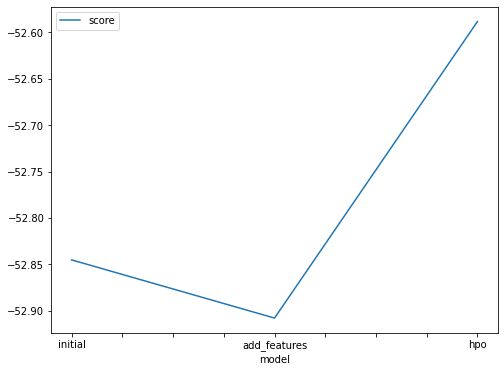

In [146]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [
            predictor.leaderboard(silent=True)['score_val'][0],
            predictor_new_features.leaderboard(silent=True)['score_val'][0],
            predictor_new_hpo.leaderboard(silent=True)['score_val'][0]
        ]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

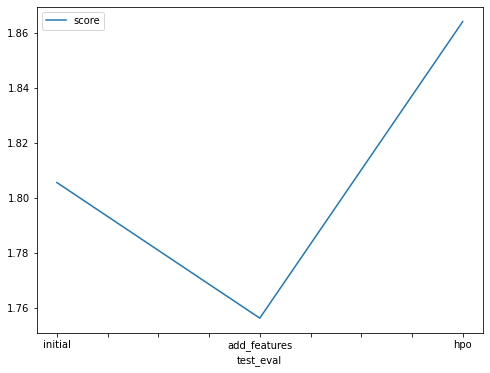

In [142]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.80562, 1.75632, 1.86412]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [143]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "net_bag_folds": [0, 0, 0],
    "net_bag_sets": [1, 1, 20],
    "net_stack_levels": [0, 0, 0],
    "score": [1.80562, 1.75632, 1.86412]
})

,model,net_bag_folds,net_bag_sets,net_stack_levels,score
0,initial,0,1,0,1.80562
1,add_features,0,1,0,1.75632
2,hpo,0,20,0,1.86412
